# 프로젝트 : 모든 장르 간 편향성 측정해 보기

지금까지 우리는 영화 시놉시스 코퍼스를 가지고 영화 구분과 영화 장르 간에 내재된 편향성을 측정하는 작업을 진행해 보았습니다. 어느 정도는 우리의 상식과 일치하는 편향성이 측정되었을 것입니다.

이번에는 모든 장르에 대해 영화 구분과의 편향성 정도를 측정해 보겠습니다. 대부분의 과정은 이전 스텝에서 이미 진행한 내용을 참고해서 동일하게 진행 가능할 것입니다.

# STEP 1. 형태소 분석기를 이용하여 품사가 명사인 경우 해당 단어를 추출하기

synopsis.txt(대략 17MB)에는 2001년부터 2019년 8월까지 제작된 영화들의 시놉시스 정보가 있습니다. (개봉된 영화 중 일부만 포함되어있습니다. 더 많은 영화 정보를 원하시면 KOBIS에서 확인하시기 바랍니다.) synopsis.txt의 일부를 읽어봅시다.
```
wget https://aiffelstaticprd.blob.core.windows.net/media/documents/synopsis.zip
$ mv synopsis.zip ~/aiffel/weat
$ cd ~/aiffel/weat && unzip synopsis.zip
```

##  다운로드된 데이터 출력 
- 2문장만 출력해준다. range(2)

In [1]:
import os

with open(os.getenv('HOME')+'/aiffel/weat/synopsis.txt', 'r') as file:
    for i in range(2):
        print(file.readline(), end='')

사운드 엔지니어 상우(유지태 분)는 치매에 걸린 할머니(백성희 분)와
 젊은 시절 상처한 한 아버지(박인환 분), 고모(신신애 분)와 함께 살고 있다.


이제 synopsis.txt 파일을 읽어 품사가 명사인 경우만 남겨 tokenized라는 변수명으로 저장해봅시다. konlpy 패키지를 이용해봅시다.
```
$ pip install konlpy
```


## 형태소 분석기를 사용해서 명사로만 표현된 데이터로 변환

In [2]:
# 약 15분정도 걸립니다.
from konlpy.tag import Okt
okt = Okt()
tokenized = []
with open(os.getenv('HOME')+'/aiffel/weat/synopsis.txt', 'r') as file:
    while True:
        line = file.readline()
        if not line: break
        words = okt.pos(line, stem=True, norm=True)
        res = []
        for w in words:
            if w[1] in ["Noun"]:      # "Adjective", "Verb" 등을 포함할 수도 있습니다.
                res.append(w[0])    # 명사일 때만 tokenized 에 저장하게 됩니다. 
        tokenized.append(res)

중복 포함해서 71156개의 토큰화된 단어가 있다.(단어 중복 포함)

In [3]:
print(len(tokenized))

71156


In [4]:
for str in tokenized[:5]: print(str)

['사운드', '엔지니어', '상우', '유지태', '분', '치매', '할머니', '백성희', '분']
['시절', '상처', '아버지', '박인환', '분', '고모', '신신애', '분', '살']
['겨울', '그', '지방', '방송국', '라디오', '은수', '이영애', '분', '를']
['자연', '소리', '채집', '라디오', '프로그램', '준비', '은수', '상우', '녹음', '여행']
['두', '사람', '날', '은수', '아파트', '밤']


# STEP 2. 추출된 결과로 embedding model 만들기


https://blog.naver.com/PostView.nhn?blogId=timtaeil&logNo=221361106051&redirect=Dlog&widgetTypeCall=true&directAccess=false
```
sentences: 학습할 문장
size: word vector의 차원(embedding size)
window: 윈도우 크기
sg: skip-gram 사용여부(1: 사용,other: CBOW)
min_count: 단어의 최소 출현수(이 크기 보다 작은 횟수로 출현하는 단어는 단어로 학습 단어로 등록되지 않음)
iter: 학습횟수
```


## gensim모델로 Word2Vec 생성

In [5]:
from gensim.models import Word2Vec

# tokenized에 담긴 데이터를 가지고 나만의 Word2Vec을 생성합니다. (Gensim 4.0 기준)
model = Word2Vec(tokenized, vector_size=100, window=5, min_count=3, sg=0)  
model.wv.most_similar(positive=['영화'])

# Gensim 3.X 에서는 아래와 같이 생성합니다. 
# model = Word2Vec(tokenized, size=100, window=5, min_count=3, sg=0)  
# model.most_similar(positive=['영화'])

/home/aiffel-dj60/anaconda3/envs/aiffel/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


[('작품', 0.892750084400177),
 ('다큐멘터리', 0.8515932559967041),
 ('드라마', 0.8326478600502014),
 ('영화로', 0.7986767888069153),
 ('코미디', 0.7834384441375732),
 ('형식', 0.7833678126335144),
 ('소재', 0.7753475904464722),
 ('스토리', 0.7720813751220703),
 ('디지털화', 0.7715620994567871),
 ('주제', 0.7673789858818054)]

In [6]:
model.wv.most_similar(positive=['사랑'])

[('첫사랑', 0.7111929655075073),
 ('행복', 0.7107906341552734),
 ('애정', 0.7016755938529968),
 ('진심', 0.6991596221923828),
 ('만남', 0.6908864378929138),
 ('가슴', 0.6878222227096558),
 ('이별', 0.6861986517906189),
 ('연애', 0.6766314506530762),
 ('감정', 0.6762307286262512),
 ('연민', 0.6620182394981384)]

In [7]:
model.wv.most_similar(positive=['행복'])

[('기쁨', 0.9143375754356384),
 ('소망', 0.8861486315727234),
 ('용기', 0.8696216940879822),
 ('슬픔', 0.8657715320587158),
 ('진정', 0.8652939200401306),
 ('좌절', 0.8607419729232788),
 ('용서', 0.8508197665214539),
 ('한구석', 0.8504756689071655),
 ('위안', 0.8498202562332153),
 ('기대', 0.8492986559867859)]

# STEP 3. target, attribute 단어 셋 만들기
WEAT score를 구할 때 단어 셋을 만들어주어야 합니다. targets_X, targets_Y, attribute_A, attribute_B를 만들어주었던 것이 기억나시죠? 그렇다면 우리는 두 축을 어떤 기준으로 잡고, 해당 축의 어떤 항목을 사용할지 정해야 합니다. 여기서는 두 축을 영화 장르, 영화 구분 정보를 이용하겠습니다. (영화 구분 정보란 일반영화, 예술영화, 독립영화로 구분된 정보입니다. KOBIS에서 제공한 정보를 기준으로 분류하였습니다. )

- 영화 구분
  - synopsis_art.txt : 예술영화
  - synopsis_gen.txt : 일반영화(상업영화)
  - 그 외 독립영화 등으로 분류됩니다.

- 장르 구분
  - synopsis_SF.txt: SF
  - synopsis_가족.txt: 가족
  - synopsis_공연.txt: 공연
  - synopsis_공포(호러).txt: 공포(호러)
  - synopsis_기타.txt: 기타
  - synopsis_다큐멘터리.txt: 다큐멘터리
  - synopsis_드라마.txt: 드라마
  - synopsis_멜로로맨스.txt: 멜로로맨스
  - synopsis_뮤지컬.txt: 뮤지컬
  - synopsis_미스터리.txt: 미스터리
  - synopsis_범죄.txt: 범죄
  - synopsis_사극.txt: 사극
  - synopsis_서부극(웨스턴).txt: 서부극(웨스턴)
  - synopsis_성인물(에로).txt: 성인물(에로)
  - synopsis_스릴러.txt: 스릴러
  - synopsis_애니메이션.txt: 애니메이션
  - synopsis_액션.txt: 액션
  - synopsis_어드벤처.txt: 어드벤처
  - synopsis_전쟁.txt: 전쟁
  - synopsis_코미디.txt: 코미디
  - synopsis_판타지.txt: 판타지

- 예술영화와 일반영화(상업영화)라는 영화구분을 target으로 삼고,드라마 장르와 액션 장르라는 장르구분을 attribute로 삼아 WEAT score를 계산해 보겠습니다

## 3.1.문장데이터를  명사 코퍼스로 변환(영화 종류target)
- konlpy(Okt) 형태소 분석기를 사용해서 텍스트 문장을 명사 코퍼로 변환해줍니다.
- 영화 종류에 대한 변수 art와 gen 변수 생성

### read_token 함수 정의
 - read_token(file_name)함수
 - 인자로 텍스트 넣어주면 Konlpy형태소 분석기( Okt)를 사용하여 문장 코퍼스를 만든다.

In [8]:
import os
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from konlpy.tag import Okt

art_txt = 'synopsis_art.txt'
gen_txt = 'synopsis_gen.txt'

def read_token(file_name):
    okt = Okt()
    result = []
    with open(os.getenv('HOME')+'/aiffel/weat/'+file_name, 'r') as fread: 
        print(file_name, '파일을 읽고 있습니다.')
        while True:
            line = fread.readline() 
            if not line: break 
            tokenlist = okt.pos(line, stem=True, norm=True) 
            for word in tokenlist:
                if word[1] in ["Noun"]:#, "Adjective", "Verb"]:
                    result.append((word[0])) 
    return ' '.join(result)

### 영화 종류(target)에 대한 변수 art와 gen 변수 생성
- 각 변수는 명사로 이루어진 2중리스트 형태이다.

In [9]:
# 2개의 파일을 처리하는데 10분 가량 걸립니다. 
art = read_token(art_txt)
gen = read_token(gen_txt)

synopsis_art.txt 파일을 읽고 있습니다.
synopsis_gen.txt 파일을 읽고 있습니다.


## 3.2 명사코퍼스(토큰화된) 데이터를 TF-IDF로 변환(영화 종류(target))

In [10]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform([art, gen])

print(X.shape)

(2, 41082)


In [11]:
print(vectorizer.vocabulary_['영화'])
print(vectorizer.get_feature_names()[23976])

23976
영화


In [12]:
print(vectorizer.vocabulary_['사랑'])
print(vectorizer.get_feature_names()[16220])

16220
사랑


## 3.3. TF-IDF를 활용하여 대표 단어 출력(영화 종류(target))

- m1,w1 : 예술영화    
- m2,w2 : 일반영화(상업영화)     

In [13]:
m1 = X[0].tocoo()   # art를 TF-IDF로 표현한 spart matrix를 가져옵니다. 
m2 = X[1].tocoo()   # gen을 TF-IDF로 표현한 spart matrix를 가져옵니다. 

- **단어 100개까지만 확인해보자**

In [14]:
m1 = X[0].tocoo()   # art를 TF-IDF로 표현한 spart matrix를 가져옵니다. 
m2 = X[1].tocoo()   # gen을 TF-IDF로 표현한 spart matrix를 가져옵니다. 

w1 = [[i, j] for i, j in zip(m1.col, m1.data)]
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

w1.sort(key=lambda x: x[1], reverse=True)   #art를 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 
w2.sort(key=lambda x: x[1], reverse=True)   #gen을 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 

print('예술영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w1[i][0]], end=', ')

print('\n')
    
print('일반영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w2[i][0]], end=', ')

예술영화를 대표하는 단어들:
그녀, 자신, 시작, 위해, 사랑, 사람, 영화, 친구, 남자, 가족, 이야기, 마을, 사건, 마음, 세상, 아버지, 아이, 엄마, 모든, 여자, 대한, 서로, 과연, 다시, 시간, 아들, 소녀, 아내, 다른, 사이, 영화제, 세계, 사실, 하나, 점점, 남편, 감독, 여행, 인생, 발견, 모두, 순간, 우리, 가장, 마지막, 생활, 아빠, 모습, 통해, 죽음, 기억, 비밀, 학교, 음악, 한편, 소년, 생각, 도시, 명의, 사고, 결혼, 전쟁, 때문, 위기, 이제, 최고, 이자, 과거, 일상, 경찰, 상황, 간다, 미국, 결심, 운명, 현실, 관계, 지금, 단편, 여인, 하루, 이름, 이후, 준비, 인간, 감정, 만난, 국제, 처음, 충격, 살인, 누구, 동안, 존재, 그린, 어머니, 연인, 계속, 동생, 작품, 

일반영화를 대표하는 단어들:
자신, 그녀, 영화제, 위해, 사람, 시작, 국제, 영화, 친구, 사랑, 남자, 이야기, 대한, 서울, 여자, 사건, 남편, 아이, 가족, 아버지, 다른, 마을, 시간, 엄마, 아들, 모든, 단편, 마음, 사실, 다시, 세계, 모습, 작품, 통해, 생각, 서로, 세상, 발견, 감독, 아내, 관계, 소녀, 사이, 하나, 우리, 애니메이션, 때문, 여성, 죽음, 과연, 점점, 인간, 생활, 한편, 결혼, 상황, 모두, 기억, 명의, 소년, 여행, 가장, 간다, 순간, 이제, 도시, 비밀, 학교, 과거, 가지, 이자, 경찰, 마지막, 미국, 동안, 전쟁, 주인공, 대해, 존재, 현실, 연출, 사고, 살인, 일상, 어머니, 계속, 사회, 인생, 다큐멘터리, 부문, 섹스, 최고, 바로, 동생, 의도, 하루, 위기, 계획, 정체, 한국, 

## 3.4 100개의 단어들 중 중복되는 단어를 제외하고 상위 n(=15)개의 단어를 추출(영화 종류(target))

두 개념을 대표하는 단어를 TF-IDF가 높은 순으로 추출하고 싶었는데, 양쪽에 중복된 단어가 너무 많은 것을 볼 수 있습니다. 두 개념축이 대조되도록 대표하는 단어 셋을 만들고 싶기 때문에 중복되지 않게 추출하도록 합니다. 우선 상위 100개의 단어들 중 중복되는 단어를 제외하고 상위 n(=15)개의 단어를 추출합니다.

In [15]:
n = 15
w1_, w2_ = [], []
for i in range(100):
    w1_.append(vectorizer.get_feature_names()[w1[i][0]])
    w2_.append(vectorizer.get_feature_names()[w2[i][0]])

# w1에만 있고 w2에는 없는, 예술영화를 잘 대표하는 단어를 15개 추출한다.
target_art, target_gen = [], []
for i in range(100):
    if (w1_[i] not in w2_) and (w1_[i] in model.wv): target_art.append(w1_[i])
    if len(target_art) == n: break 

# w2에만 있고 w1에는 없는, 일반영화를 잘 대표하는 단어를 15개 추출한다.
for i in range(100):
    if (w2_[i] not in w1_) and (w2_[i] in model.wv): target_gen.append(w2_[i])
    if len(target_gen) == n: break

In [16]:
print(target_art)

['아빠', '음악', '결심', '운명', '지금', '여인', '이름', '이후', '준비', '감정', '만난', '처음', '충격', '누구', '그린']


In [17]:
print(target_gen)

['서울', '애니메이션', '여성', '가지', '주인공', '대해', '연출', '사회', '다큐멘터리', '부문', '섹스', '바로', '의도', '계획', '정체']


## 3.5 장르attributes 데이터 전처리

이번에는 장르별 대표 단어를 추출해 봅시다. 이번에는 드라마 장르와 액션 장르를 다루어 보려고 합니다. 그러나 그렇다고 해서 드라마와 액션 단 2개의 장르만 고려하기보다는 여러 장르의 코퍼스를 두루 고려하는 것이 특정 장르를 대표하는 단어를 선택하는 데 더 유리할 것입니다. 이번에는 주요 장르 5개만 고려해 봅시다.

In [18]:

genre_txt = ['synopsis_SF.txt', 'synopsis_family.txt', 'synopsis_show.txt', 'synopsis_horror.txt', 'synopsis_etc.txt', 
             'synopsis_documentary.txt', 'synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_musical.txt', 
             'synopsis_mystery.txt', 'synopsis_crime.txt', 'synopsis_historical.txt', 'synopsis_western.txt', 
             'synopsis_adult.txt', 'synopsis_thriller.txt', 'synopsis_animation.txt', 'synopsis_action.txt', 
             'synopsis_adventure.txt', 'synopsis_war.txt', 'synopsis_comedy.txt', 'synopsis_fantasy.txt']
genre_name = ['SF', '가족', '공연', '공포(호러)', '기타', '다큐멘터리', '드라마', '멜로로맨스', '뮤지컬', '미스터리', '범죄', '사극', '서부극(웨스턴)',
         '성인물(에로)', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁', '코미디', '판타지']

In [19]:
# 약 10분정도 걸립니다.
genre = []
for file_name in genre_txt:
    genre.append(read_token(file_name))

synopsis_SF.txt 파일을 읽고 있습니다.
synopsis_family.txt 파일을 읽고 있습니다.
synopsis_show.txt 파일을 읽고 있습니다.
synopsis_horror.txt 파일을 읽고 있습니다.
synopsis_etc.txt 파일을 읽고 있습니다.
synopsis_documentary.txt 파일을 읽고 있습니다.
synopsis_drama.txt 파일을 읽고 있습니다.
synopsis_romance.txt 파일을 읽고 있습니다.
synopsis_musical.txt 파일을 읽고 있습니다.
synopsis_mystery.txt 파일을 읽고 있습니다.
synopsis_crime.txt 파일을 읽고 있습니다.
synopsis_historical.txt 파일을 읽고 있습니다.
synopsis_western.txt 파일을 읽고 있습니다.
synopsis_adult.txt 파일을 읽고 있습니다.
synopsis_thriller.txt 파일을 읽고 있습니다.
synopsis_animation.txt 파일을 읽고 있습니다.
synopsis_action.txt 파일을 읽고 있습니다.
synopsis_adventure.txt 파일을 읽고 있습니다.
synopsis_war.txt 파일을 읽고 있습니다.
synopsis_comedy.txt 파일을 읽고 있습니다.
synopsis_fantasy.txt 파일을 읽고 있습니다.


In [20]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(genre)

print(X.shape)

(21, 42191)


In [21]:
m = [X[i].tocoo() for i in range(X.shape[0])]

w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]

for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True)
attributes = []
for i in range(len(w)):
    print(genre_name[i], end=': ')
    attr = []
    j = 0
    while (len(attr) < 15):
        if vectorizer.get_feature_names()[w[i][j][0]] in model.wv:
            attr.append(vectorizer.get_feature_names()[w[i][j][0]])
            print(vectorizer.get_feature_names()[w[i][j][0]], end=', ')
        j += 1
    attributes.append(attr)
    print()

SF: 위해, 자신, 지구, 시작, 사람, 인류, 인간, 미래, 우주, 그녀, 로봇, 세계, 모든, 박사, 우주선, 
가족: 엄마, 아빠, 가족, 영화제, 자신, 위해, 친구, 아주르, 아버지, 시작, 그녀, 아들, 마을, 국제, 낙타, 
공연: 오페라, 사랑, 토스카, 실황, 올레, 자신, 카바, 그녀, 공연, 오텔로, 리골레토, 백작, 프레, 베르디, 위해, 
공포(호러): 시작, 위해, 사람, 자신, 친구, 그녀, 사건, 공포, 발견, 죽음, 마을, 가족, 악령, 남자, 좀비, 
기타: 영화제, 국제, 서울, 단편, 영화, 자신, 사람, 이야기, 그녀, 남자, 위해, 시작, 사랑, 뉴미디어, 페스티벌, 
다큐멘터리: 영화제, 영화, 다큐, 국제, 다큐멘터리, 사람, 이야기, 대한, 자신, 감독, 위해, 서울, 우리, 시작, 세계, 
드라마: 자신, 영화제, 그녀, 사람, 사랑, 영화, 위해, 시작, 국제, 남자, 친구, 이야기, 엄마, 여자, 아버지, 
멜로로맨스: 그녀, 사랑, 자신, 시작, 남편, 남자, 여자, 사람, 친구, 섹스, 위해, 마음, 결혼, 서로, 아내, 
뮤지컬: 뮤지컬, 사랑, 에스메랄다, 그녀, 음악, 충무로, 모차르트, 영화, 토스카, 자신, 니웨, 카바, 영화제, 바흐, 페뷔스, 
미스터리: 사건, 그녀, 시작, 자신, 위해, 사람, 발견, 사고, 진실, 죽음, 기억, 살인, 친구, 아내, 남자, 
범죄: 사건, 위해, 자신, 경찰, 시작, 그녀, 범죄, 조직, 살인, 사람, 마약, 형사, 남자, 모든, 살해, 
사극: 조선, 위해, 시작, 신기전, 사랑, 자신, 아가멤논, 황제, 그녀, 루안, 최고, 운명, 사람, 하선, 전쟁, 
서부극(웨스턴): 서부, 보안관, 위해, 벌린, 카우보이, 그레이프바인, 헨리, 마을, 자신, 개릿, 아이, 시작, 무법자, 프린트, 마적, 
성인물(에로): 그녀, 남편, 마사지, 자신, 섹스, 관계, 영화, 정사, 남자, 위해, 시작, 여자, 유부녀, 마음, 사랑, 
스릴러: 자신, 그녀, 사건, 

각 장르를 대표하는 단어들을 추출해보았습니다. 우리가 생각했던 직관과 데이터에 있는 단어들이 잘 맞나요? 중복된 것이 종종 있지만 art, gen 두 개의 단어 셋을 추출했을 때에 비해 적습니다. 그러므로 중복을 체크해서 삭제하기보다 그대로 사용하겠습니다.

## STEP 4. WEAT score 계산과 시각화
영화 구분, 영화 장르에 따른 편향성을 측정하여 WEAT score로 계산해 보고 이를 Heatmap 형태로 시각화해 봅시다. 편향성이 두드러지는 영화장르 attribute 구성에는 어떤 케이스가 있는지 시각적으로 두드러지게 구성되면 좋습니다.

이제 WEAT_score를 구해봅시다. traget_A는 art, target_B는 gen, attribute_X는 '드라마', attribute_Y는 '액션' 과 같이 정해줄 수 있습니다.

target_A 는 art, target_B 는 gen으로 고정하고 attribute_X, attribute_Y를 바꿔가면서 구해봅시다. 구한 결과를 21x21 매트릭스 형태로 표현해서 matrix 라는 변수에 담아봅시다.

In [22]:
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]

## 4.1 WEAT score 계산
WEAT socre의 이 편향성 값은 -2에서 2사이의 값을 가지게 되며, 그 절댓값이 클수록 w 는 A-B 개념축에 대해 편향성을 가진다는 뜻이 됩니다.
- cos_sim(i, j)함수
- weat_score(X, Y, A, B)함수

In [23]:
from numpy import dot
from numpy.linalg import norm

def cos_sim(i, j):
    return dot(i, j.T) / (norm(i)*norm(j))

def s(w, A, B):
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)
    mean_A = np.mean(c_a, axis=-1)
    mean_B = np.mean(c_b, axis=-1)
    return mean_A - mean_B

def weat_score(X, Y, A, B):
    
    s_X = s(X, A, B)
    s_Y = s(Y, A, B)
    
    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)
    
    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))
    
    return (mean_X - mean_Y) / std_dev

In [24]:
A = np.array([model.wv[word] for word in target_art])
B = np.array([model.wv[word] for word in target_gen])

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        X = np.array([model.wv[word] for word in attributes[i]])
        Y = np.array([model.wv[word] for word in attributes[j]])
        matrix[i][j] = weat_score(X, Y, A, B)

matrix를 채워보았습니다. WEAT score 값이 2와 -2에 가까운 수치들을 보고, 과연 우리의 직관과 비슷한지 살펴볼까요?

In [25]:
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        if matrix[i][j] > 1.1 or matrix[i][j] < -1.1:
            print(genre_name[i], genre_name[j],matrix[i][j])

SF 멜로로맨스 -1.3442556
공포(호러) 다큐멘터리 1.1769655
기타 멜로로맨스 -1.1910348
다큐멘터리 멜로로맨스 -1.4895889
다큐멘터리 미스터리 -1.2887002
다큐멘터리 성인물(에로) -1.2422287
다큐멘터리 스릴러 -1.1682826
멜로로맨스 범죄 1.2549052
멜로로맨스 서부극(웨스턴) 1.1636806
멜로로맨스 애니메이션 1.1660095
멜로로맨스 전쟁 1.410362


## 4.2시각화

예술영화와 일반영화, 그리고 다큐멘터리와 멜로로맨스의 WEAT score의 의미를 해석해보면 예술 영화는 멜로로맨스와 가깝고, 다큐멘터리는 일반 영화와 가깝다고 볼 수 있습니다.

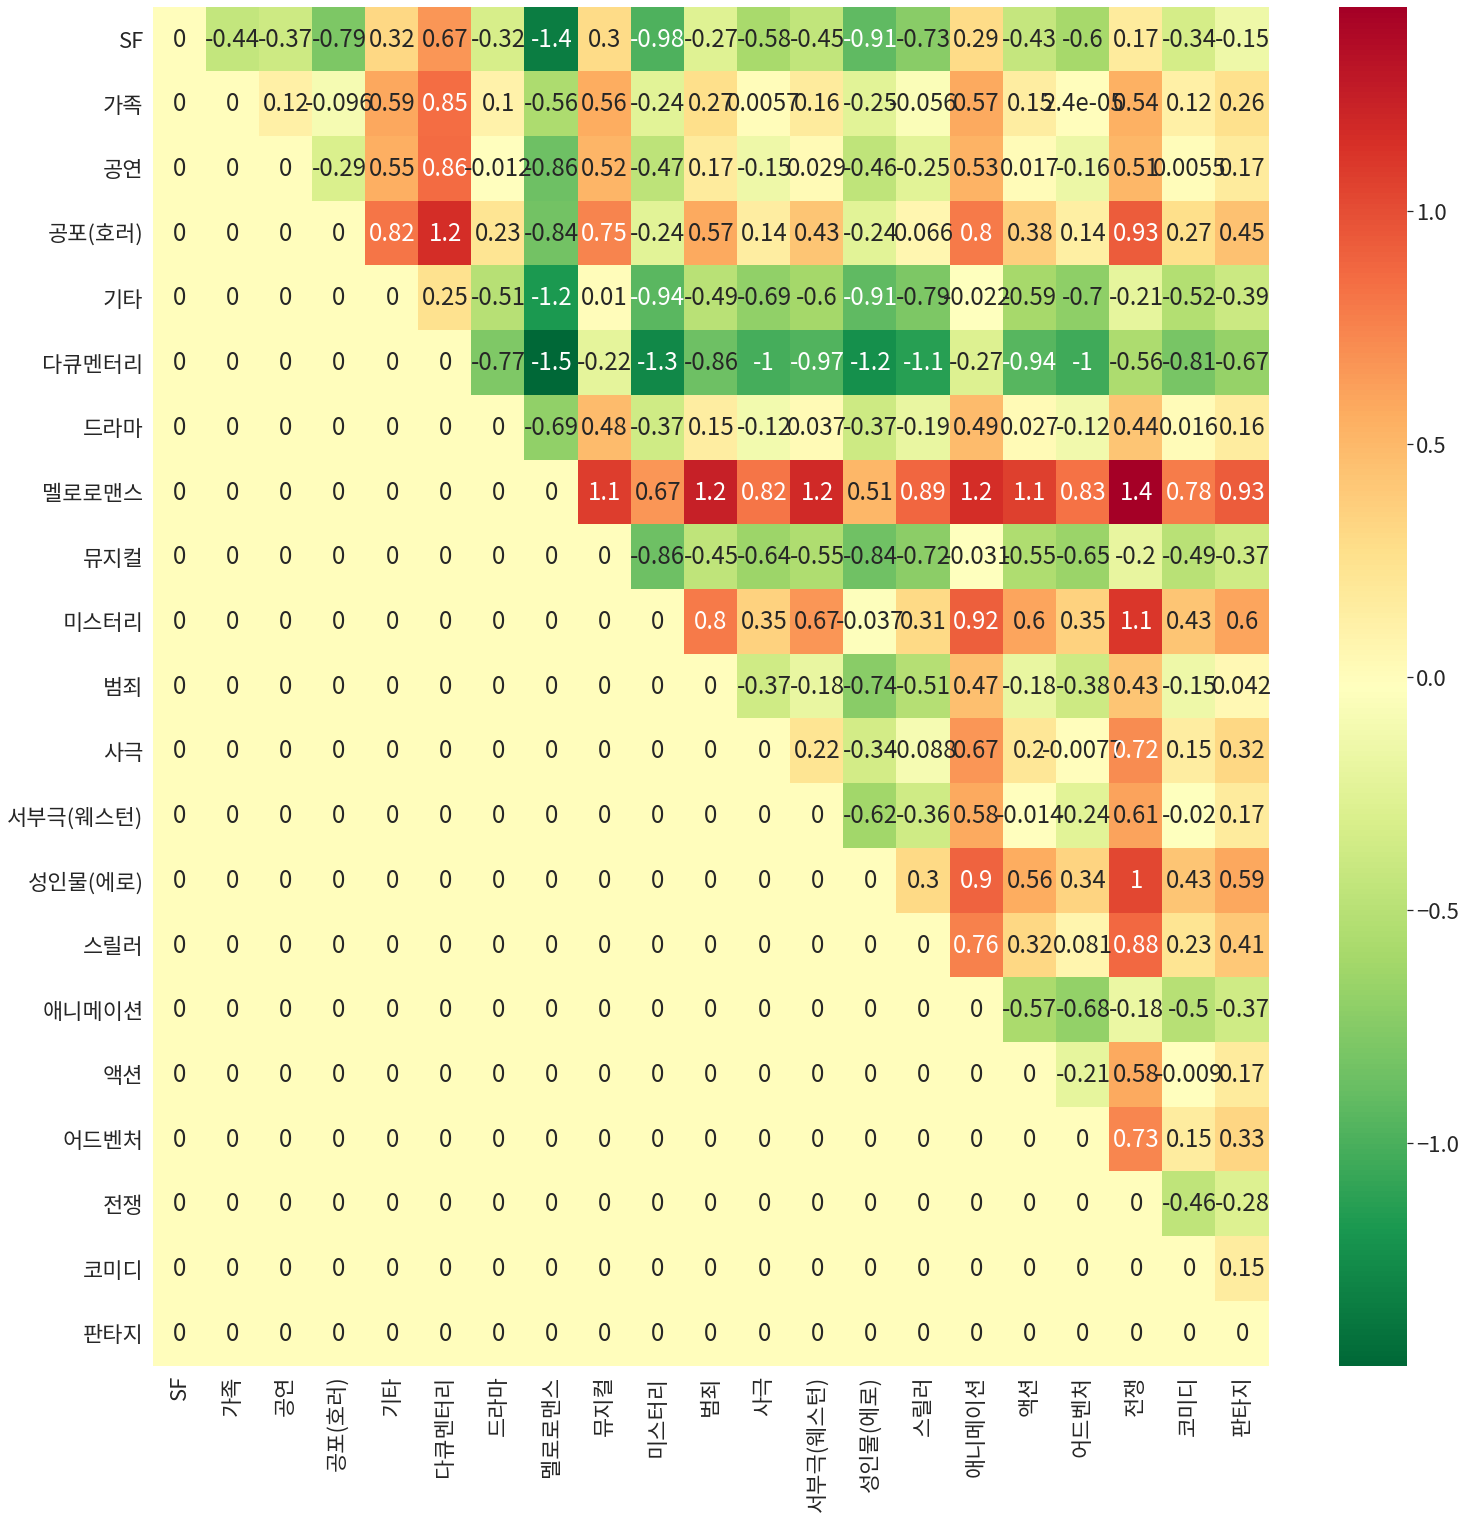

In [108]:
import numpy as np; 
import seaborn as sns; 
import matplotlib.pyplot as plt
%matplotlib inline
 
fig, ax = plt.subplots(figsize=(25,25))

np.random.seed(0)

# 한글 지원 폰트
sns.set(font="Noto Sans CJK JP",font_scale=2)
ax = sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name, annot=True,  cmap='RdYlGn_r')
ax
plt.show()

 **WEAT socre의 이 편향성 값은 -2에서 2사이의 값을 가지게 되며, 그 절댓값이 클수록 w 는 A-B 개념축에 대해 편향성을 가진다는 뜻이 됩니다.**
 
 
**편향이 큰경우**
```

공포(호러) -  다큐먼트      (1.2)
멜로로맨스 -  서부극(웨스턴) (1.2)
멜로로맨스 -  애니메이션    (1.2)
멜로로맨스 -  전쟁        (1.4)
다큐멘터리 -  멜로로맨스   (-1.5) 
다큐멘터리 -  미스터리    (-1.3)
```
**편향이 작은 경우**
```
드라마        - 코미디 (0.016)
서부극(웨스턴) - 코미티(-0.02)
드라마       -  스릴러 (-0,19)
어드벤처     -  코미디 (0.15 )
범죄        -  판타지 (0.042) 
```

참고로 이 score값이 가치있는 의미인지 모르겠다.

# STEP 5. 다른방법의 대표 단어 셋을 구축
- 영화(예술영화,일반영화)데이터에서 중복 제외한 모든 단어 w1,w2 각각 저장 
- 그중 중복되지 않는 30개의 단어 추출

**`3.4 100개의 단어들 중 중복되는 단어를 제외하고 상위 n(=15)개의 단어를 추출(영화 종류)`**에서 상위 단어들 중 중복되는 단어를 제외하고 상위 30개의 단어를 추출하였습니다. 이번에는 모든 단어에 대한 중복 데이터를 제거하겠습니다.


In [27]:
#19:01시작 -> 19:38
n = 30
w1_, w2_ = [], []
for i in range(len(w1)): # w1 길이만큼 돌려준다.
    w1_.append(vectorizer.get_feature_names()[w1[i][0]])

for i in range(len(w2)): # w2 길이만큼 돌려준다.
    w2_.append(vectorizer.get_feature_names()[w2[i][0]])

target_art, target_gen = [], []

# w1에만 있고 w2에는 없는, 예술영화를 잘 대표하는 단어를 추출한다.
for i in range(len(w1)):
    if (w1_[i] not in w2_) and (w1_[i] in model.wv): target_art.append(w1_[i])
    #if len(target_art) == n: break 
        
# w2에만 있고 w1에는 없는, 일반영화를 잘 대표하는 단어를 추출한다.
for i in range(len(w2)):
    if (w2_[i] not in w1_) and (w2_[i] in model.wv): target_gen.append(w2_[i])
    #if len(target_gen) == n: break

In [28]:
print(len(target_art))
print(target_art)

30
['부스', '권투', '병풍', '여진', '십만원', '꾸러미', '불복', '생면부지', '크메르', '윤성호', '소훈', '소량', '요양', '줄리엣', '일편단심', '가짜', '소개', '들꽃', '룸바', '가요제', '리무진', '눈싸움', '불참', '아르덴', '거리공연', '대행', '학생', '거제도', '승연', '고원']


In [29]:
print(len(target_gen))
print(target_gen)

30
['심심함', '데어데블', '퀘스트', '코트', '겹치기', '맨손', '캐롤', '물리', '에티엔느', '여로', '블랙유머', '건일', '성은', '예상외', '골몰', '수첩', '잘츠부르크', '처방', '사운드트랙', '나무꾼', '송미', '공약', '나기', '기슭', '마다가스카', '카밀라', '술술', '취득', '레이블', '주니어']


In [30]:
import numpy as np

A = np.array([model.wv[word] for word in target_art])
B = np.array([model.wv[word] for word in target_gen])

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        X = np.array([model.wv[word] for word in attributes[i]])
        Y = np.array([model.wv[word] for word in attributes[j]])
        matrix[i][j] = weat_score(X, Y, A, B)

In [31]:
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        if matrix[i][j] > 1.1 or matrix[i][j] < -1.1:
            print(genre_name[i], genre_name[j],matrix[i][j])

SF 가족 -1.2892898
SF 공연 -1.1665654
SF 기타 -1.4092269
SF 다큐멘터리 -1.2802783
SF 드라마 -1.4153398
SF 멜로로맨스 -1.4411228
SF 뮤지컬 -1.4772654
SF 성인물(에로) -1.496755
SF 스릴러 -1.1157953
SF 애니메이션 -1.354358
SF 코미디 -1.2599171
SF 판타지 -1.1013021
가족 전쟁 1.259577
공연 전쟁 1.1442232
공포(호러) 성인물(에로) -1.1961198
기타 범죄 1.1239533
기타 전쟁 1.3793024
다큐멘터리 전쟁 1.2545389
드라마 범죄 1.1405344
드라마 전쟁 1.3869765
멜로로맨스 범죄 1.1986612
멜로로맨스 액션 1.1575394
멜로로맨스 전쟁 1.4159342
뮤지컬 범죄 1.253756
뮤지컬 액션 1.175633
뮤지컬 전쟁 1.4441621
미스터리 성인물(에로) -1.1363128
범죄 성인물(에로) -1.3045018
성인물(에로) 액션 1.2607874
성인물(에로) 전쟁 1.4737681
애니메이션 전쟁 1.3243134
전쟁 코미디 -1.2358346


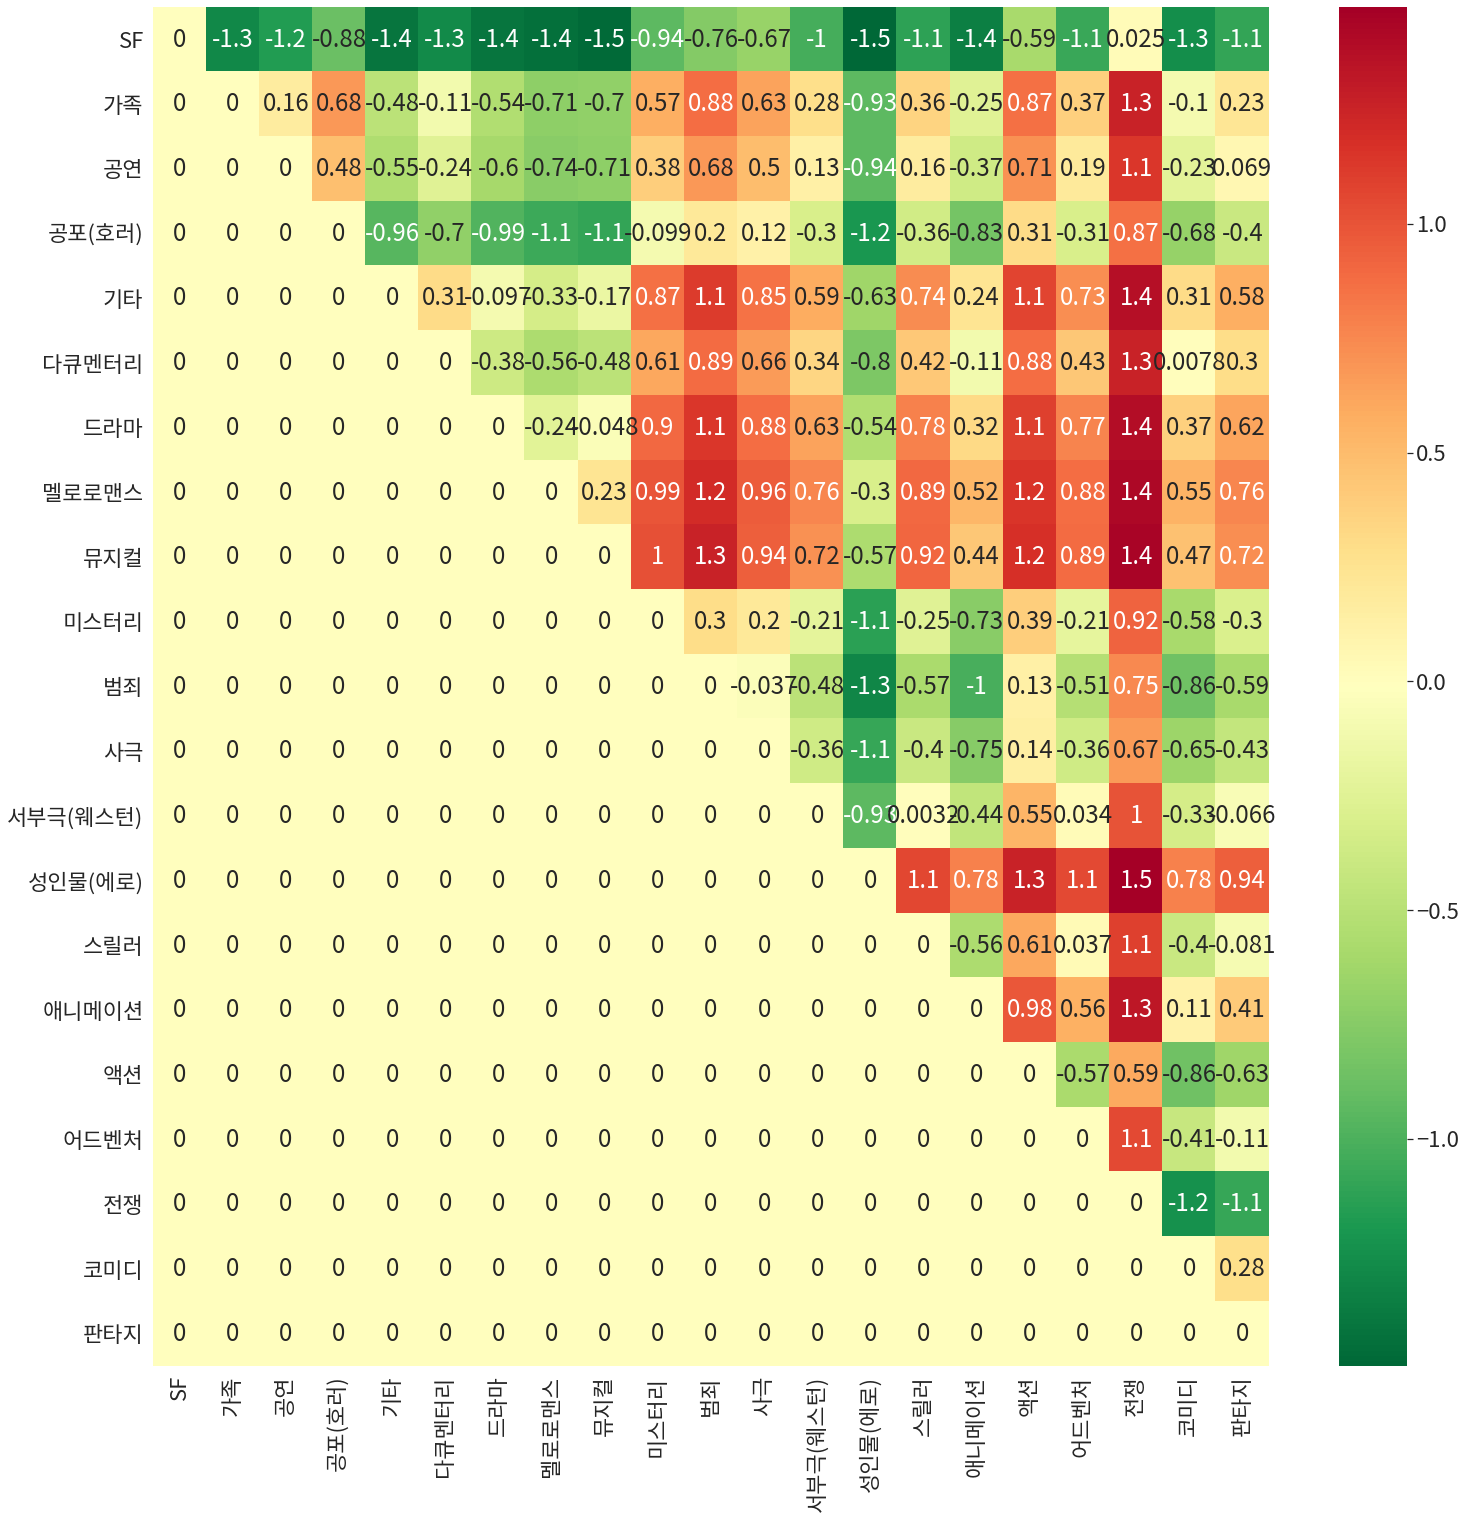

In [33]:
import numpy as np; 
import seaborn as sns; 
import matplotlib.pyplot as plt
%matplotlib inline
 
fig, ax = plt.subplots(figsize=(25,25))

np.random.seed(0)

# 한글 지원 폰트
sns.set(font="Noto Sans CJK JP",font_scale=2)
ax = sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name, annot=True,  cmap='RdYlGn_r')
ax
plt.show()

# 되짚어 보기
- 예술영화와 일반영화(상업영화)라는 영화구분을 target으로 삼고, 드라마 장르와 액션 장르라는 장르구분을 attribute로 삼아 WEAT score를 계산해 보았다.이것의 의미는, 드라마 장르에는 예술영화적 성격이 강하고, 액션 장르에는 일반(상업)영화적 성격이 강할 것이라는 편향성이 워드 임베딩 상에 얼마나 나타나고 있는지를 측정하는것이다.

- 드라마 장르에는 예술영화적 성격이 강하고, 액션 장르에는 일반(상업)영화적 성격이 강할 것이라는 편향성이 워드 임베딩 상에 얼마나 나타나고 있는지를 측정해 보겠다는 것

# 내가 이해한 바

WEAT는 X-Y축과 A-B축을 활용합니다. X,Y,A,B 각각은 의미,속성이 같은 각각의 집합입니다.    
X-Y은 target, A-B는 attrubute라고합니다. 즉 2개의 집합 X,Y target에 대한 각각의 의미를 함유하는 집합 A,B를 설정합니다.그래서 WEAT의 점수를 확인하여 편향성을 파악합니다.    
프로젝트에서는 타겟이 예술영화와 일반(상업)영화로 고정되어 있고, 애튜리뷰트는 21개의 장르를 2개씩 뽑아 모든 경우의 수를 시각화하였습니다. 그 시각화된 결과에서 우리는 타겟에 적절한 애튜리뷰트를 뽑아내어 그 데이터로 편향성을 파악해야된다고 생각됩니다. 즉 모든 weat score가 활용되지 않는다는것입니다.

# 루브릭

아래의 기준을 바탕으로 프로젝트를 평가합니다.

평가문항    
상세기준    
## 1. 주어진 영화 코퍼스를 바탕으로 워드임베딩 모델을 정상적으로 만들었다.    
워드임베딩의 most_similar() 메소드 결과가 의미상 바르게 나왔다.    
## 2. 영화 구분, 장르별로 target, attribute에 대한 대표성있는 단어 셋을 생성하였다. 
타당한 방법론을 통해 중복이 잘 제거되고 개념축을 의미적으로 잘 대표하는 단어 셋이 만들어졌다.    
## 3. WEAT score 계산 및 시각화를 정상적으로 진행하였다.    
전체 영화 장르별로 예술/일반 영화에 대한 편향성 WEAT score가 상식에 부합하는 수치로 얻어졌으며 이를 잘 시각화하였다.    

konlpy okt 사용법: https://blog.naver.com/navehag/222322441582     
gensim word2vec 사용법 : https://blog.naver.com/navehag/222322466815

## word2Vec 사용법

In [ ]:
len(model.wv.key_to_index)
model.wv.word_vec
dir(model.wv)
len(model.wv.get_vector(0))